# DSA 210 Caffeine Consumption and the Effect of Exams on it.
This is the notebook for my project, here I will explain how my data was handled, and how I plotted the charts.

*For a detailed explanation of how my original data files were created and constructed please read the corresponding part on my presentation.*

Both of the original files were in .csv format, you may find them inside the project folder as "DSA210 Manually Logged Consumption" and "DSA210 Application Logged Consumption", please take a look at them to further understand the format.

Both files have a different format so I needed to run some code to prepare them for usage.

For the conversion of pieces of drinks to caffeine amounts, I have done some research through the internet and calculated the average caffeine content of the products. Unless it is a specially brewed or consturcted coffee most coffees of the same size have the same amount of espresso in them. The caffeine content of the drinks I have consumed were calculated and converted using the chart below:
|Drink/Size | Caffeine per Cup/Can (mg)|
|---|---|
|Mid Coffee(s)| 63|
|Large Coffee(s) | 126|
|Cortado | 126|
|Filter Coffee | 155|
|BlackEye | 281|
|RedEye | 218|
|Cold Brew | 200|
|Tea | 50|
|Energy Drink | 80|


Part 1: Converting the two differently logged data into caffeine

In [1]:
#converts the application data
import pandas as pd
import re

df = pd.read_csv("C:/Users/mabag/Desktop/DSA210 Application Logged Consumption.csv", sep=";")

#here we define caffeine values for the drinks
caffeine_map = {
    "Cortado": 126,
    "Filter": 155,
    "BlackEye": 281,
    "RedEye": 218,
    "ColdBrew": 200,
    "Mid": 63,
    "Large": 126
}

#this function returns the total amount of caffeine for that day
def parse_logged(entry):
    if pd.isna(entry):
        return 0
    total = 0
    for part in entry.split("-"):
        match = re.match(r"(\d+)\s(.+)", part.strip())
        if match:
            count = int(match.group(1))
            drink = match.group(2).strip()
            if drink in caffeine_map:
                total += count * caffeine_map[drink]
    return total

df["caffeine"] = df["Coffee"].apply(parse_logged)
df.drop(columns=["Coffee"], inplace=True)

#saving the data to a new file 
df.to_csv("C:/Users/mabag/Desktop/ApplicationCaffeine.csv", index=False, sep=";")

In [2]:
#converts the hand logged data
import pandas as pd

df = pd.read_csv("C:/Users/mabag/Desktop/DSA210 Manually Logged Consumption.csv", sep=',')

#caffeine calculation
df["caffeine"] = (
    df["tea"] * 50 +
    df["filter coffee"] * 155 +
    df["energy drink"] * 80
)

#we only keep the date and caffeine columns
df = df[["Date", "caffeine"]]

#saving the data to a new file 
df.to_csv("C:/Users/mabag/Desktop/ManualCaffeine.csv", index=False)


Part 2: Merging the two data and formattig the data

In [3]:
import pandas as pd

df1 = pd.read_csv("C:/Users/mabag/Desktop/ApplicationCaffeine.csv", sep=";")
df2 = pd.read_csv("C:/Users/mabag/Desktop/ManualCaffeine.csv")

#merge dates
merged = pd.merge(df1, df2, on="Date", suffixes=("_desc", "_item"))

#getting the total caffeine
merged["Total Caffeine"] = merged["caffeine_desc"] + merged["caffeine_item"]
finalDf = merged[["Date", "Exam", "Total Caffeine"]]

#saving the data to a new file 
finalDf.to_csv("C:/Users/mabag/Desktop/MergedCaffeineData.csv", index=False)

In [4]:
import pandas as pd

mergedDF = pd.read_csv("C:/Users/mabag/Desktop/MergedCaffeineData.csv")

#converts the date into the format we want and converts the floats to integers
mergedDF["Date"] = pd.to_datetime(mergedDF["Date"], dayfirst=True) 
mergedDF["Total Caffeine"] = mergedDF["Total Caffeine"].round().astype(int)

#initialising columns
mergedDF["Within 1 Week Before Exam"] = 0
mergedDF["Within 3 Days Before Exam"] = 0
mergedDF["1 Day Before Exam"] = 0
mergedDF["On Exam Day"] = 0

#get the exam dates
examDates = mergedDF.loc[mergedDF["Exam"] == 1, "Date"].tolist()

#here we assign the proximity tag by looking at the days until an exam
for i, row in mergedDF.iterrows():
    currentDate = row["Date"]
    closestExam = None
    minDays = float("inf")

    #finds the closest exam(not before)
    for examDate in examDates:
        delta_days = (examDate - currentDate).days
        if 0 <= delta_days < minDays:
            minDays = delta_days
            closestExam = examDate

    #one-hot-like assigning based on remaining days to exam
    if minDays == 0:
        mergedDF.at[i, "On Exam Day"] = 1
    elif minDays == 1:
        mergedDF.at[i, "1 Day Before Exam"] = 1
    elif minDays in [2, 3]:
        mergedDF.at[i, "Within 3 Days Before Exam"] = 1
    elif 4 <= minDays <= 7:
        mergedDF.at[i, "Within 1 Week Before Exam"] = 1

#assigning the proximity level tags by looking at the one-hot-like encoding
def assignProximity(row):
    if row["On Exam Day"] == 1:
        return "On Exam Day"
    elif row["1 Day Before Exam"] == 1:
        return "1 Day Before Exam"
    elif row["Within 3 Days Before Exam"] == 1:
        return "Within 3 Days Before Exam"
    elif row["Within 1 Week Before Exam"] == 1:
        return "Within 1 Week Before Exam"
    else:
        return "Not Related to Exam"

mergedDF["Exam Proximity"] = mergedDF.apply(assignProximity, axis=1)
mergedDF["Exam Related"] = mergedDF["Exam Proximity"].apply(lambda x: "Related to Exam" if x != "Not Related to Exam" else "Not Related to Exam")

#formatting rhe final output
final = mergedDF[[
    "Date",
    "Within 1 Week Before Exam",
    "Within 3 Days Before Exam",
    "1 Day Before Exam",
    "On Exam Day",
    "Total Caffeine",
    "Exam Proximity",
    "Exam Related"
]].rename(columns={"Total Caffeine": "Caffeine Consumption"}).reset_index(drop=True)


final.to_csv("C:/Users/mabag/Desktop/FormattedExamCaffeineData.csv", index=False)

After we run the final code we should get our final data. With this data we can start working on inspecting it.

# Below here are the codes written to plot the graphs/tables.

In [5]:
#importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
#for the box plots
import seaborn as sns
#for t-test
import numpy as np
from scipy.stats import t
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, LeaveOneOut
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from dmba import classificationSummary
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve


In [6]:
#loading the dataset
df = pd.read_csv("C:/Users/mabag/Desktop/FormattedExamCaffeineData.csv")
df["Date"] = pd.to_datetime(df["Date"])
df["Caffeine Consumption"] = pd.to_numeric(df["Caffeine Consumption"], errors="coerce").fillna(0)

In [7]:
df.groupby(["Exam Proximity"])["Caffeine Consumption"].mean()

Exam Proximity
1 Day Before Exam            207.857143
Not Related to Exam           92.962406
On Exam Day                  139.500000
Within 1 Week Before Exam    108.800000
Within 3 Days Before Exam    142.380952
Name: Caffeine Consumption, dtype: float64

In [8]:
df.groupby(["Exam Proximity"])["Caffeine Consumption"].median()

Exam Proximity
1 Day Before Exam            155.0
Not Related to Exam           63.0
On Exam Day                  126.0
Within 1 Week Before Exam     81.5
Within 3 Days Before Exam    150.0
Name: Caffeine Consumption, dtype: float64

In [9]:
df.groupby(["Exam Related"])["Caffeine Consumption"].mean()

Exam Related
Not Related to Exam     92.962406
Related to Exam        140.721519
Name: Caffeine Consumption, dtype: float64

In [10]:
df.groupby(["Exam Related"])["Caffeine Consumption"].median()

Exam Related
Not Related to Exam     63.0
Related to Exam        150.0
Name: Caffeine Consumption, dtype: float64

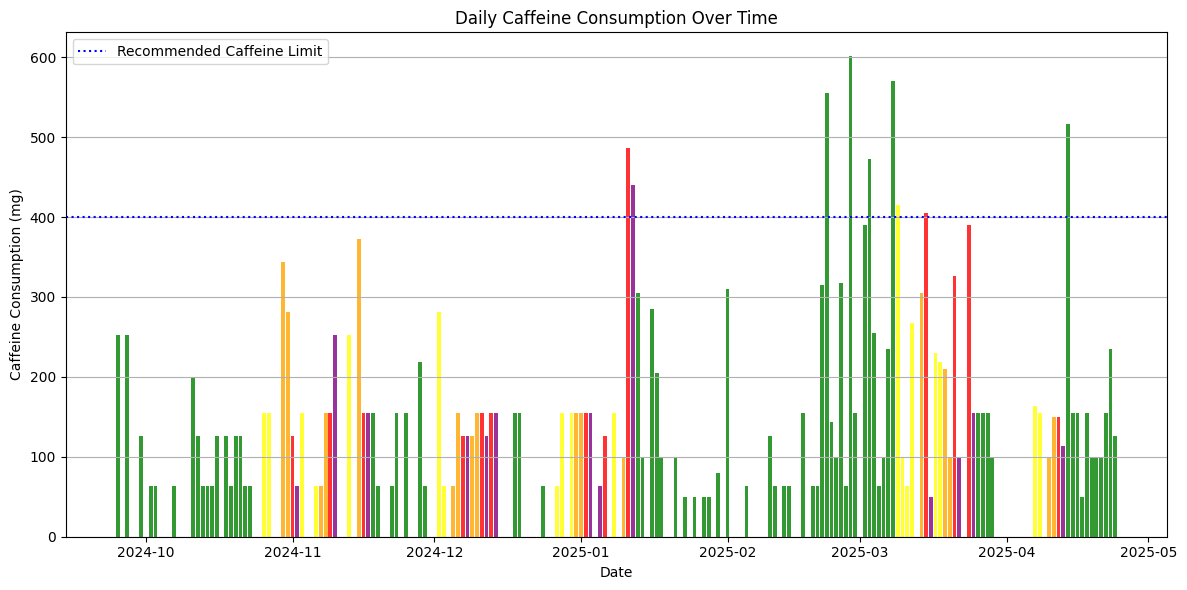

In [11]:
#code for the bar chart based on exam proximity

#defining the color map for exam proximities
colorMap = {
    "Not Related to Exam":"green",
    "Within 1 Week Before Exam":"yellow",
    "Within 3 Days Before Exam":"orange",
    "1 Day Before Exam":"red",
    "On Exam Day":"purple"
}

#adding a new column for color based on Exam Proximity
df["Color"] = df["Exam Proximity"].map(colorMap)

#plotting the caffeine consumption for each day with color coding
plt.figure(figsize=(12, 6))
bars = plt.bar(df["Date"], df["Caffeine Consumption"], color=df["Color"].values, alpha=0.8)

#adding title and labels to the figure
plt.title("Daily Caffeine Consumption Over Time")
plt.xlabel("Date")
plt.ylabel("Caffeine Consumption (mg)")

plt.axhline(y=400, color='b', linestyle=':')
plt.legend(["Recommended Caffeine Limit"], loc="upper left")
plt.grid(True, axis='y')
plt.xticks()
plt.tight_layout()
plt.show()


C:\Users\mabag\AppData\Local\Temp\ipykernel_23632\4157663886.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


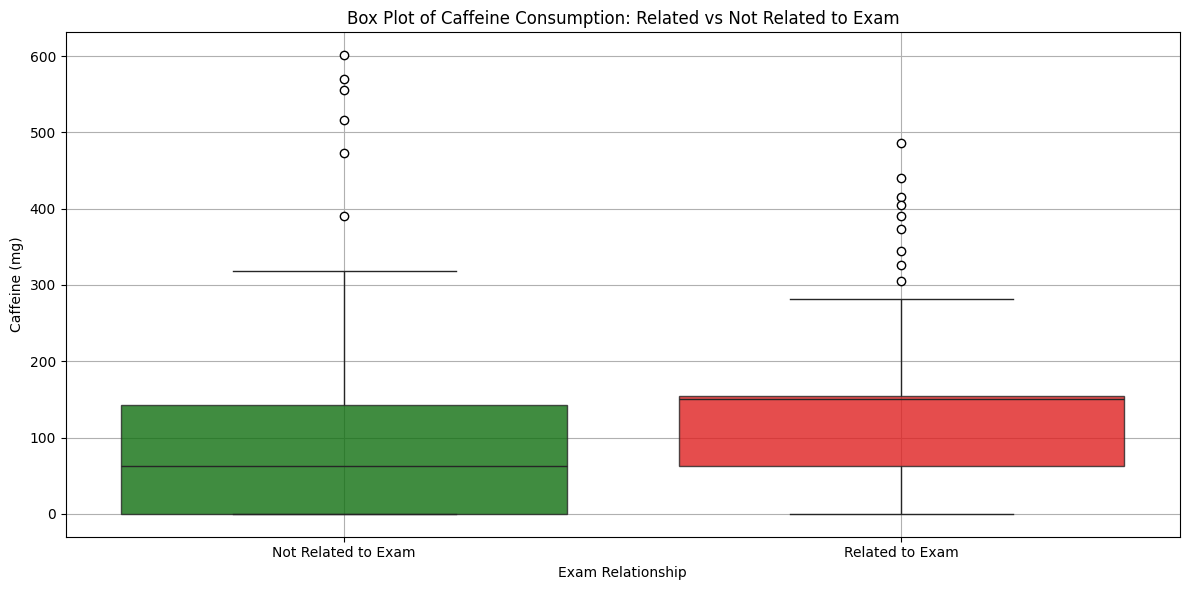

In [12]:
#code for the box-plot of the days in maximum 1 week proximity of an exam and days unrelated

colorMap = {
    "Not Related to Exam":"green",
    "Related to Exam":"red"
}

#plotting the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df,
    x="Exam Related",
    y="Caffeine Consumption",
    flierprops=dict(marker="o", markerfacecolor="white", markeredgecolor="black", markersize=6, linestyle="none"),
    boxprops=dict(alpha= 0.8),
    palette= colorMap
)
plt.title("Box Plot of Caffeine Consumption: Related vs Not Related to Exam")
plt.xlabel("Exam Relationship")
plt.ylabel("Caffeine (mg)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
from scipy.stats import ttest_ind

NotRelated = df[df["Exam Related"] == 'Not Related to Exam']["Caffeine Consumption"]
related = df[df["Exam Related"] == 'Related to Exam']["Caffeine Consumption"]

tStat, pValue = ttest_ind(NotRelated, related, equal_var=False)

print("T-Statistic:", tStat,"\n" , "P Value:", pValue)


T-Statistic: -2.790345208227106 
 P Value: 0.005859627546978205


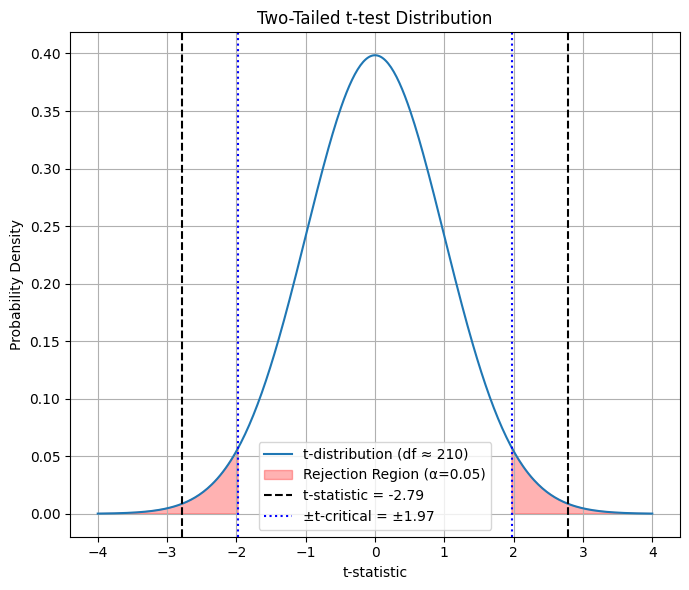

In [14]:
#code for the t-distribution

#generating values t distribution
x = np.linspace(-4, 4, 400)
y = t.pdf(x, 210)

alpha = 0.05
tCritical = t.ppf(1 - alpha / 2, 210)

#Plotting with critical t-values
plt.figure(figsize=(7, 6))
plt.plot(x, y, label=f"t-distribution (df ≈ {210})")
plt.fill_between(x, y, where=(x <= -tCritical) | (x >= tCritical), color="red", alpha=0.3, label="Rejection Region (α=0.05)")
plt.axvline(tStat, color="black", linestyle="--", label=f't-statistic = {tStat:.2f}')
plt.axvline(-tStat, color="black", linestyle="--")
plt.axvline(tCritical, color="blue", linestyle=":", label=f'±t-critical = ±{tCritical:.2f}')
plt.axvline(-tCritical, color="blue", linestyle=":")

plt.title("Two-Tailed t-test Distribution")
plt.xlabel("t-statistic")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
#code for calculating t-test of different proximities.

noRelation = df[df["Exam Proximity"] == 'Not Related to Exam']["Caffeine Consumption"]
oneWeek = df[df["Exam Proximity"] == "Within 1 Week Before Exam"]["Caffeine Consumption"]
threeDays = df[df["Exam Proximity"] == "Within 3 Days Before Exam"]["Caffeine Consumption"]
oneDay = df[df["Exam Proximity"] == "1 Day Before Exam"]["Caffeine Consumption"]
examDay = df[df["Exam Proximity"] == "On Exam Day"]["Caffeine Consumption"]


tStat1, pValue1 = ttest_ind(noRelation, oneWeek, equal_var=False)
print("T-Statistic:", tStat1,"\n" , "P Value:", pValue1)
print()
tStat2, pValue2 = ttest_ind(oneWeek, threeDays, equal_var=False)
print("T-Statistic:", tStat2,"\n" , "P Value:", pValue2)
print()
tStat3, pValue3 = ttest_ind(threeDays, oneDay, equal_var=False)
print("T-Statistic:", tStat3,"\n" , "P Value:", pValue3)
print()
tStat4, pValue4 = ttest_ind(oneDay, examDay, equal_var=False)
print("T-Statistic:", tStat4,"\n" , "P Value:", pValue4)


T-Statistic: -0.6926913220634389 
 P Value: 0.4918823043921825

T-Statistic: -1.0690586952907544 
 P Value: 0.2909897953430043

T-Statistic: -1.493435815567023 
 P Value: 0.1484557348654092

T-Statistic: 1.4772414591352112 
 P Value: 0.15237922521395125


C:\Users\mabag\AppData\Local\Temp\ipykernel_23632\1707146999.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


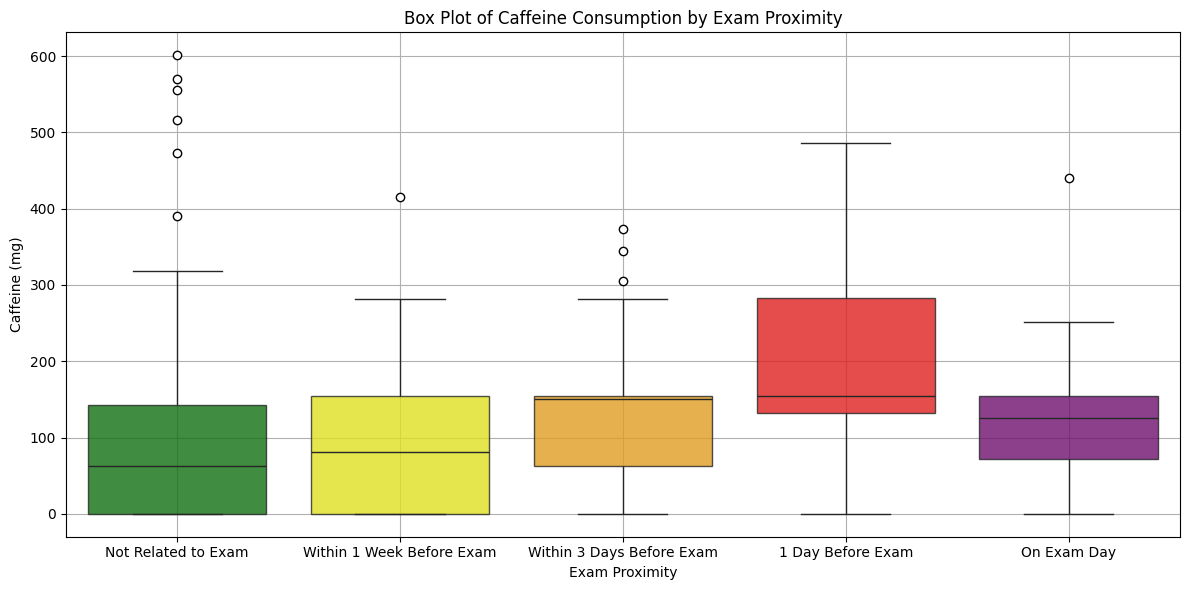

In [16]:
#code for the box plot of days with different proximity levels

#define color map for proximity levels
colorMap = {
    "Not Related to Exam":"green",
    "Within 1 Week Before Exam":"yellow",
    "Within 3 Days Before Exam":"orange",
    "1 Day Before Exam":"red",
    "On Exam Day":"purple"
}

#adding color based on exam proximity
df["Color"] = df["Exam Proximity"].map(colorMap)

#plotting the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df,
    x="Exam Proximity",
    y="Caffeine Consumption",
    flierprops=dict(marker='o', markerfacecolor='white', markeredgecolor="black", markersize=6),
    boxprops=dict(alpha=0.8),
    palette= colorMap
)
plt.title("Box Plot of Caffeine Consumption by Exam Proximity")
plt.xlabel("Exam Proximity")
plt.ylabel("Caffeine (mg)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Below this part are the ML methods I have used to predict certain elements

#### 1 - Predicting the amount of caffeine to be consumed on a day depending on the proximity of the next exam day using Linear Regression, K-Fold, Leave-One-Out, KNNs and other methods

In [17]:
predictors1 = ["Within 1 Week Before Exam", "Within 3 Days Before Exam", "1 Day Before Exam", "On Exam Day"]
X1 = pd.get_dummies(df[predictors1], dtype=int, drop_first=1)
Y1 = df["Caffeine Consumption"]

In [18]:
# Linear Regression Intercept and Coefficients
caffeineLm = LinearRegression()
caffeineLm.fit(X1, Y1)

print(f'Intercept: {caffeineLm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X1.columns, caffeineLm.coef_):
    print(f' {name}: {coef}')

Intercept: 92.962
Coefficients:
 Within 1 Week Before Exam: 15.837593984962425
 Within 3 Days Before Exam: 49.418546365914764
 1 Day Before Exam: 114.89473684210542
 On Exam Day: 46.537593984962456


In [19]:
# Linear Regression and Some MSE and RMSE values
low_mse1 = 999999
high_mse1 = 0
iterations = 4000
for i in range(iterations):
    # Split data into training and test sets
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, Y1)

    # Training and evaluation
    model1 = LinearRegression()
    model1.fit(X_train1, y_train1)
    y_pred1 = model1.predict(X_test1)
    mse1 = mean_squared_error(y_test1, y_pred1)
    
    if (mse1 > high_mse1):
        high_mse1 = mse1
    if (mse1 < low_mse1):
        low_mse1 = mse1

low_rmse1 = np.sqrt(low_mse1)
print(f"Lowest Validation Set MSE: {low_mse1:.2f}")
print(f"Lowest Validation Set RMSE: {low_rmse1:.2f}")
print()

high_rmse1 = np.sqrt(high_mse1)
print(f"Highest Validation Set MSE: {high_mse1:.2f}")
print(f"Highest Validation Set RMSE: {high_rmse1:.2f}")
print()

rmse1 = np.sqrt(mse1)
print(f"Validation Set MSE: {mse1:.2f}")
print(f"Validation Set RMSE: {rmse1:.2f}")

Lowest Validation Set MSE: 5776.87
Lowest Validation Set RMSE: 76.01

Highest Validation Set MSE: 31967.67
Highest Validation Set RMSE: 178.80

Validation Set MSE: 12771.47
Validation Set RMSE: 113.01


You can see the MSE and RMSE results above. Lets take a look at the RMSE values since they are on the same unit as my caffeine data

The lowest and highest RMSE values were calculated to be roughly 75 and 175 respectively under 4000 iterations

In [20]:
# k-Fold Cross-Validation
kf1 = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores1 = cross_val_score(model1, X1, Y1, cv=kf1, scoring='neg_mean_squared_error')

# Convert negative MSE to positive
cv_mse_scores1 = -cv_scores1
print("10-Fold CV MSE Scores:", cv_mse_scores1)
print(f"Average CV MSE: {cv_mse_scores1.mean():.2f}")


print(f"Average CV RMSE: {np.sqrt(cv_mse_scores1.mean()):.2f}")

10-Fold CV MSE Scores: [14364.94678581 21270.54407081 15146.23233663 13516.00357773
  9693.94732101 19206.48993322 24288.59879176 12218.16447317
 10917.53541584 10411.62110753]
Average CV MSE: 15103.41
Average CV RMSE: 122.90


With the 10-Fold Cross-Validation above we get an average RMSE of 122.9 . Lets also calculate the R^2 value


In [21]:
cv_scoresR2 = cross_val_score(model1, X1, Y1, cv=kf1, scoring='r2')

print(f"Mean R^2 Score: {cv_scoresR2.mean():.2f}")

Mean R^2 Score: -0.05


In [22]:
# Leave-One-Out Cross-Validation
loo1 = LeaveOneOut()
cv_scores_loo1 = cross_val_score(model1, X1, Y1, cv=loo1, scoring='neg_mean_squared_error')

# Convert to positive MSE
mse_loo1 = -cv_scores_loo1
print(f"Average LOOCV MSE: {mse_loo1.mean():.2f}")
print(f"Average LOOCV RMSE: {np.sqrt(mse_loo1.mean()):.2f}")

Average LOOCV MSE: 15072.93
Average LOOCV RMSE: 122.77


Again with the Leave-One-Out Cross-Validation we get an average RMSE of 122.7 .

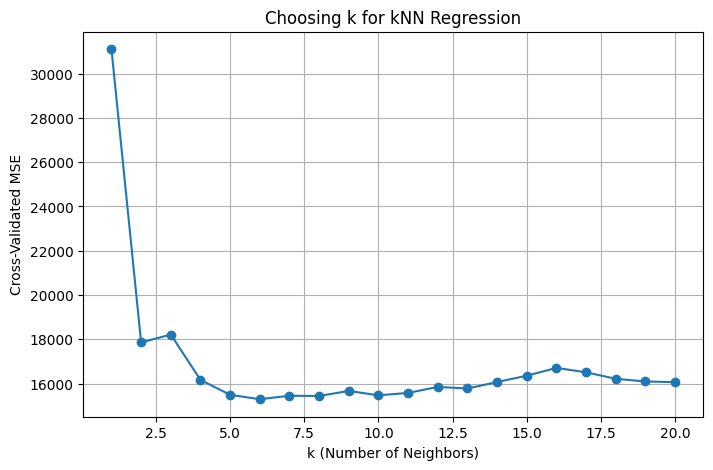

Best k: 6
MSE for k=6: 15296.209939091917
RMSE for k=6: 123.6778474064451
R^2 for depth=6: -1.4352444494787067


In [ ]:
# kNN
k_values1 = list(range(1, 21))
cv_scores1 = []
r2cv_scores1 = []

for k in k_values1:
    model1 = KNeighborsRegressor(n_neighbors=k)
    scores1 = cross_val_score(model1, X1, Y1, cv=5, scoring='neg_mean_squared_error')
    r2scores1 = cross_val_score(model1, X1, Y1, cv=5, scoring='r2')
    cv_scores1.append(-scores1.mean())  # convert from negative MSE
    r2cv_scores1.append(r2scores1.mean())

# Plot k vs MSE
plt.figure(figsize=(8, 5))
plt.plot(k_values1, cv_scores1, marker='o')
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Cross-Validated MSE")
plt.title("Choosing k for kNN Regression")
plt.grid(True)
plt.show()

best_k = k_values1[np.argmin(cv_scores1)]
best_mse = cv_scores1[np.argmin(cv_scores1)]
best_r2 = r2cv_scores1[np.argmin(r2cv_scores1)]
best_rmse = np.sqrt(best_mse)
print(f"Best k: {best_k}")
print(f"MSE for k={best_k}: {best_mse}")
print(f"RMSE for k={best_k}: {best_rmse}")
print(f"R^2 for depth={best_k}: {best_r2}")

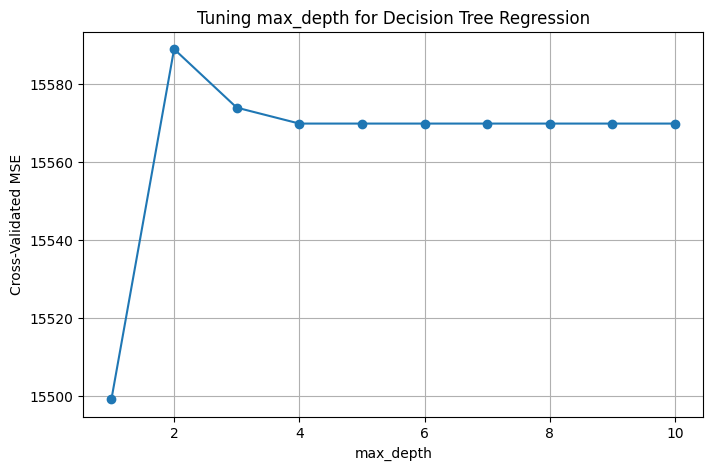

Best max_depth: 1
MSE for depth=1: 15499.244548915887
RMSE for depth=1: 124.49596197835449
R^2 for depth=1: -2.307187179654841


In [24]:
depths1 = list(range(1, 11))
cv_scores1 = []
r2cv_scores1 = []

for d in depths1:
    tree1 = DecisionTreeRegressor(max_depth=d, random_state=1)
    scores1 = cross_val_score(tree1, X1, Y1, cv=50, scoring='neg_mean_squared_error')
    r2scores1 = cross_val_score(tree1, X1, Y1, cv=50, scoring='r2')
    cv_scores1.append(-scores1.mean())
    r2cv_scores1.append(r2scores1.mean())

# Plot
plt.figure(figsize=(8, 5))
plt.plot(depths1, cv_scores1, marker='o')
plt.xlabel("max_depth")
plt.ylabel("Cross-Validated MSE")
plt.title("Tuning max_depth for Decision Tree Regression")
plt.grid(True)
plt.show()

best_depth1 = depths1[np.argmin(cv_scores1)]
best_r2 = r2cv_scores1[np.argmin(r2cv_scores1)]
best_mse = cv_scores1[np.argmin(cv_scores1)]
best_rmse = np.sqrt(best_mse)
print(f"Best max_depth: {best_depth1}")
print(f"MSE for depth={best_depth1}: {best_mse}")
print(f"RMSE for depth={best_depth1}: {best_rmse}")
print(f"R^2 for depth={best_depth1}: {best_r2}")

In [ ]:
depths1 = [3, 4, 5, 10, 15, 20, 25] # while i tuned with the values a little a depth of 4 and an n of 36 work well together.
estimators1 = [10, 36, 50, 100, 150, 200]
results1 = {}
r2results1 = {}

for d in depths1:
    for n in estimators1:
        rf1 = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=42)
        score1 = cross_val_score(rf1, X1, Y1, cv=5, scoring='neg_mean_squared_error').mean()
        r2score1 = cross_val_score(rf1, X1, Y1, cv=5, scoring='r2').mean()
        results1[(d, n)] = -score1
        r2results1[(d, n)] = r2score1

# Find best combination
best_params1 = min(results1, key=results1.get)
print(f"Best max_depth: {best_params1[0]}, Best n_estimators: {best_params1[1]}")
print(f"Best CV MSE: {results1[best_params1]:.2f}")
print(f"Best CV RMSE: {np.sqrt(results1[best_params1]):.2f}")
print(f"Best R^2: {r2results1[best_params1]:.2f}")



Best max_depth: 4, Best n_estimators: 36
Best CV MSE: 15590.51
Best CV RMSE: 124.86
Best R^2: -0.03


#### 2 - Predicting the existence of an exam within a week of the day by the amount of caffeine consumed on that day using Logistic Regression

Confusion Matrix (Accuracy 0.6744)

       Prediction
Actual  0  1
     0 26  2
     1 12  3

Prevalence: 0.35
Precision: 0.6
Recall: 0.2
Specificity: 0.93
Accuracy: 0.67
ROC AUC: 0.69


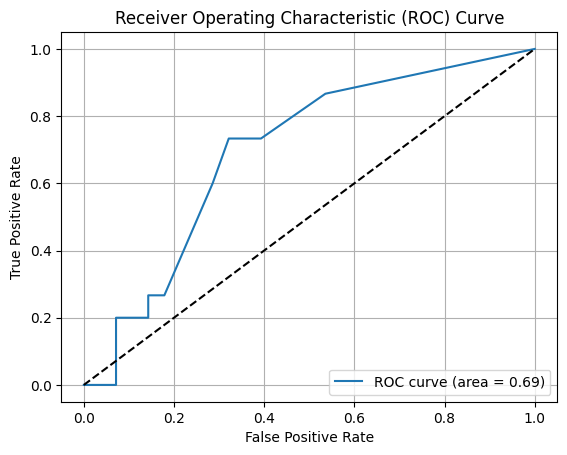

In [ ]:
df["Exam Related(ENC)"] = df["Exam Related"].apply(lambda x: 1 if x == "Related to Exam" else 0)
predictor_logitreg = "Caffeine Consumption"
outcome_logitreg = "Exam Related(ENC)"

X2 = df[[predictor_logitreg]]
y2 = df[outcome_logitreg]
X2_train_logitreg, X2_test_logitreg, y2_train_logitreg, y2_test_logitreg = train_test_split(X2, y2, test_size = 0.2, random_state = 42)

logit_reg = LogisticRegression() 
logit_reg.fit(X2_train_logitreg, y2_train_logitreg) 

pd.DataFrame(data = {'Coefs': np.concatenate((logit_reg.intercept_, logit_reg.coef_[0]))}, 
             index = np.concatenate((['Intercept'], X2_test_logitreg.columns)))
pred_logitreg = pd.DataFrame(logit_reg.predict_proba(X2_test_logitreg), 
                             columns = logit_reg.classes_)
pred = logit_reg.predict(X2_test_logitreg)
classificationSummary(y2_test_logitreg, pred, class_names = logit_reg.classes_)
y_scores = logit_reg.predict_proba(X2_test_logitreg)
y_scores = y_scores[:, 1]

# Calculate metrics
conf_matrix = confusion_matrix(y2_test_logitreg, pred)
roc_auc = roc_auc_score(y2_test_logitreg, y_scores)

# The number for the calculation for some of the metrics were entered manually, where;
TruePositive = 26
FalsePositive = 12
FalseNegative = 2
TrueNegative = 3
print("")
print(f"Prevalence: {round((FalsePositive+TrueNegative)/(TruePositive+FalseNegative+FalsePositive+TrueNegative), 2)}")
print(f"Precision: {round(TrueNegative/(FalseNegative+TrueNegative), 2)}")
print(f"Recall: {round(TrueNegative/(FalsePositive+TrueNegative), 2)}")
print(f"Specificity: {round(TruePositive/(TruePositive+FalseNegative), 2)}")
print(f"Accuracy: {round((TruePositive+TrueNegative)/(TruePositive+FalseNegative+FalsePositive+TrueNegative), 2)}")
print(f"ROC AUC: {roc_auc:.2f}")

# Ploting ROC Curve
fpr, tpr, thresholds = roc_curve(y2_test_logitreg, y_scores)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In regards of AUC we can say that;
- AUC = 1: Perfect model
- AUC = 0.5: Model with no discriminative ability

With my calculations it can be seen that my model with an AUC of 0.69 is not close to perfection. Since the data that was fed is not too great It would be safe to say that the model is relatively good.